In [2]:
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Scale-free network

#### Discrete Formalism

As node degrees are positive integers, $k = 0, 1, 2, \ldots$, the discrete formalism provides the probability $p_k$ that a node has exactly $k$ links

The distribution of a scale free network is given by

$$ p_k = Ck^{-\gamma} $$

This distribution is called a power law distribution and the exponent $\gamma$ is its degree exponent. If we take a logarithm of this equation, we obtain

$$ \log p_k \sim -\gamma \log k $$

$\log p_k$ is depend linearly on $\log k$, the slope of this line being the degree exponent $\gamma$.

#### Hubs

Comparison of Random networks and Scale-free networks:

1. For small $k$ the power law is above the Poisson function, indicating that a scale-free network has a large number of small degree nodes, most of which are absent in a random network.
2. For $k$ in the vicinity of $\langle k \rangle$ the Poisson distribution is above the power law, indicating that in a random network there is an excess of nodes with degree $k \approx \langle k \rangle$.
3. For large $k$ the power law is again above the Poisson curve. The difference is particularly visible if we show $p_k$ on a log-log plot, indicating that the probability of observing a high-degree node, or hub, is several orders of magnitude higher in a scale-free network than in a random network.

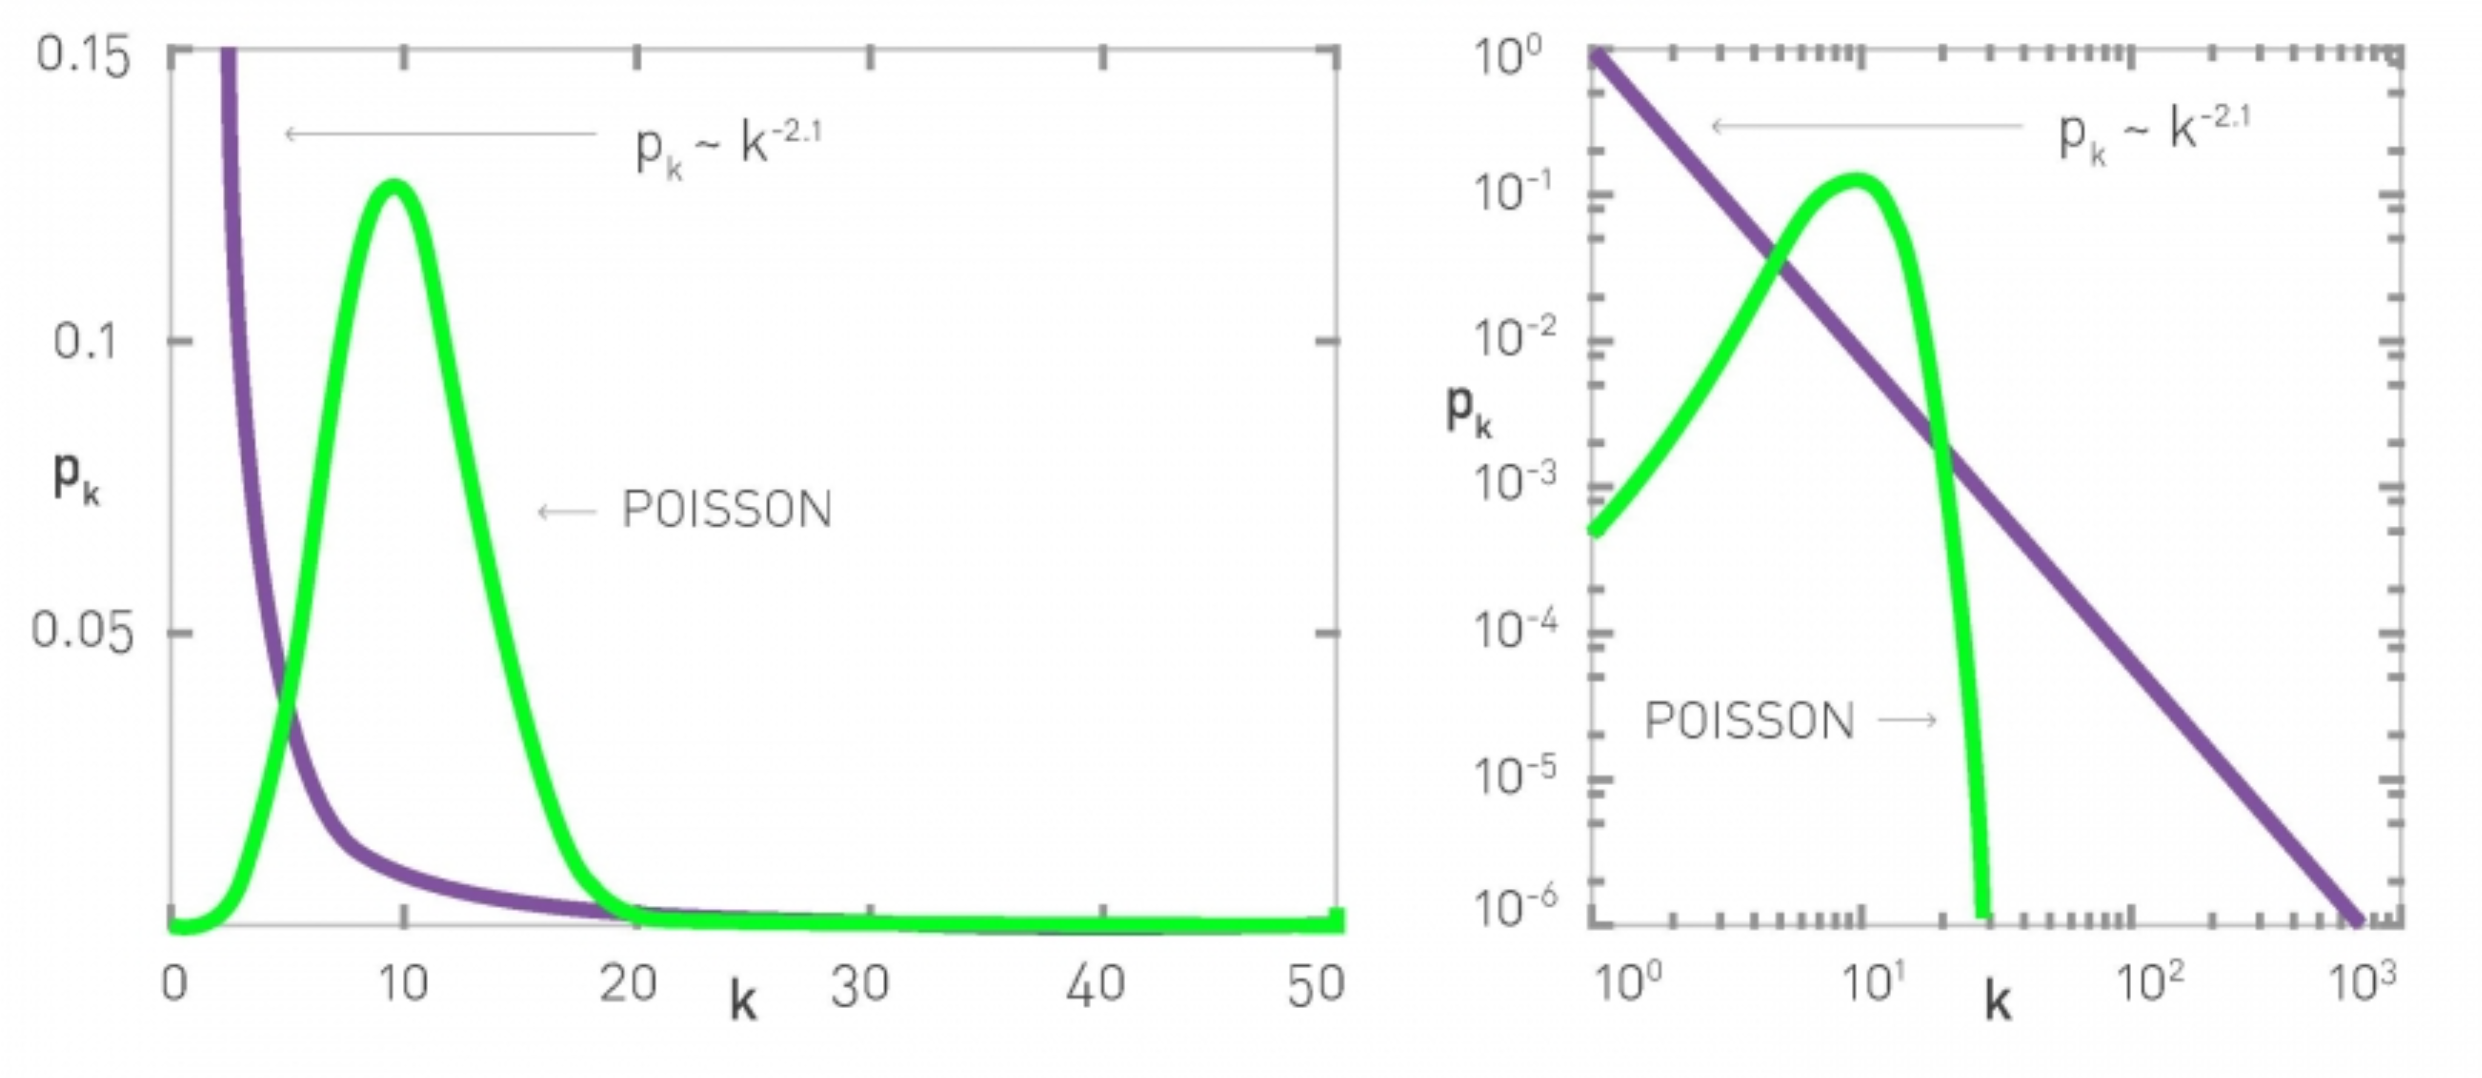

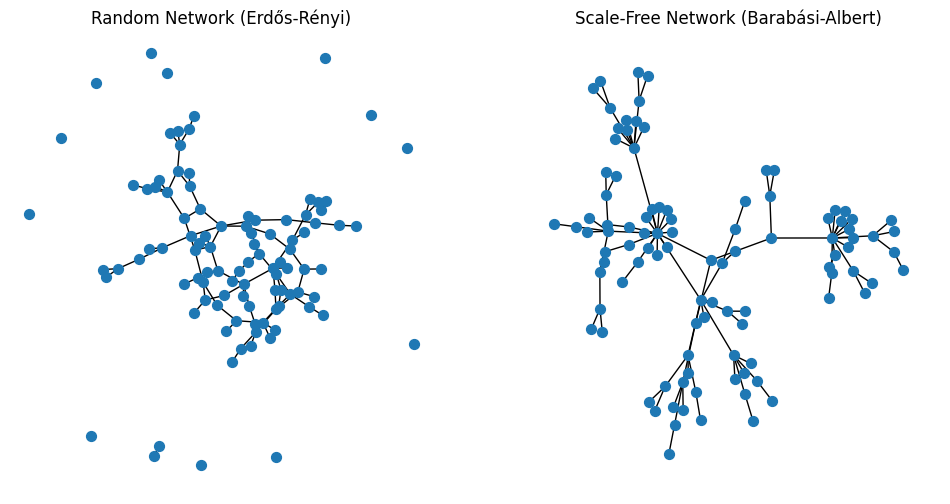

In [84]:
N = 100
mean_k = 2
p = mean_k / (N - 1) 

# Generate a random network
G_random = nx.erdos_renyi_graph(N, p)

# Generate a scale free network
m = 1
G_scale_free = nx.barabasi_albert_graph(N, m)

plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw(G_random, node_size=50, with_labels=False)
plt.title("Random Network (Erdős-Rényi)")

plt.subplot(122)
nx.draw(G_scale_free, node_size=50, with_labels=False)
plt.title("Scale-Free Network (Barabási-Albert)")

plt.show()

# Epidemic Modeling

##  Susceptible-Infected (SI) model

Consider a disease that spreads in a population of $N$ individuals.

#### Defenitions:

$S(t)$ - the number of individuals who are susceptible (healthy) at time $t$.

$I(t)$ - the number individuals that have been already infected.

$\langle k \rangle$ - the typical number of contacts of each individual.

$\beta$ -  the likelihood that the disease will be transmitted from an infected to a susceptible individual in a unit time.

#### Initial conditions:

At time $t=0$ everyone is susceptible $(S(0)=N)$ and no one is infected $(I(0)=0)$.

#### Question:

If a single individual becomes infected at time $t=0$ (i.e. $I(0)=1$), how many individuals will be infected at some later time $t$?

### Equation for $I(t)$

$$
\frac{dI(t)}{dt} = \beta \langle k \rangle \frac{S(t)I(t)}{N}
$$

#### Explanation:

Within the homogenous mixing hypothesis the probability that the infected person encounters a susceptible individual is $\frac{S(t)}{N}$.

Therefore the infected person comes into contact with $\frac{〈k〉S(t)}{N}$ susceptible individuals in a unit time.

#### Change of variables:

$$
s(t) = \frac{S(t)}{N}, \quad i(t) = \frac{I(t)}{N} 
$$

as the fraction of the susceptible and of the infected population at time $t$.

The equation for $i(t)$ becomes:

$$
\frac{di}{dt} = \beta \langle k \rangle s i = \beta \langle k \rangle i (1 - i)
$$

The equation for $s(t)$ is given by:

$$
\frac{ds}{dt} = -\beta \langle k \rangle s i = - \beta \langle k \rangle i (1 - i)
$$

#### Analytical solution:

$$
i = \frac{i_0 e^{\beta \langle k \rangle t}}{1 - i_0 + i_0 e^{\beta \langle k \rangle t}}
$$

The characteristic time required to reach an $ \frac{1}{e} $ fraction (about 36%) of all susceptible individuals is 

$$
\tau = \frac{1}{\beta \langle k \rangle} 
$$

Hence $ \tau $ is the inverse of the speed with which the pathogen spreads through the population.

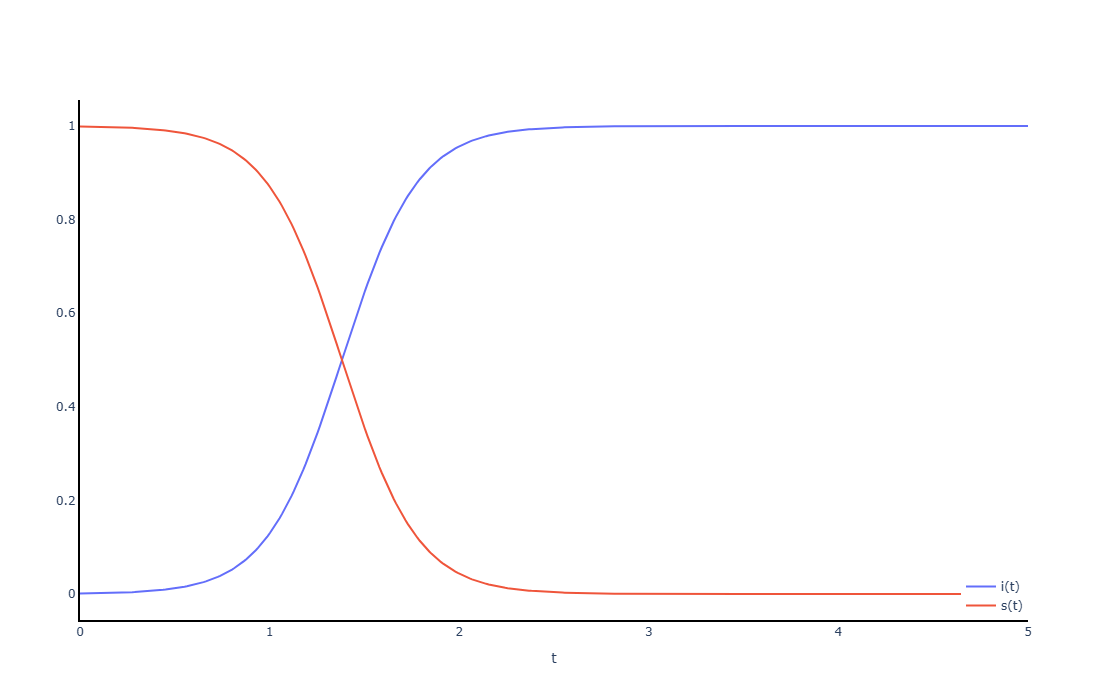

In [2]:
beta = 0.5
k = 10
t = np.linspace(0, 5, 400)  

def si(t, i0, beta, k):
    I_t = i0*np.exp(beta*k*t)/(1-i0+i0*np.exp(beta*k*t))
    return [I_t, 1-I_t]

i0 = 0.001

fig = go.Figure()

Y = si(t, i0, beta, k)
fig.add_trace(go.Scatter(x=t, y=Y[0], mode='lines', name='i(t)'))
fig.add_trace(go.Scatter(x=t, y=Y[1], mode='lines', name='s(t)'))

fig.update_layout(
    xaxis_title='t',
    yaxis_title=' ',
    xaxis=dict(showgrid=False, linecolor='black', linewidth=2), 
    yaxis=dict(showgrid=False, linecolor='black', linewidth=2),  
    plot_bgcolor='white',  
    width=700,  
    height=700,
    legend=dict(
        x=1,  
        y=0,  
        xanchor='right',  
        yanchor='bottom'  
    )
)

fig.show()

## Susceptible-Infected-Susceptible (SIS) Model

The equation describing the dynamics of this model is:

$$ \frac{di}{dt} = \beta \langle k \rangle i (1 - i) - \mu i $$

where $\mu$ is the recovery rate and the $\mu i$ term captures the rate at which the population recovers from the disease. The solution of this equation provides the fraction of infected individuals as a function of time:

$$ i = \left(1 - \frac{\mu}{\beta \langle k \rangle} \right) \frac{Ce^{(\beta \langle k \rangle - \mu)t}}{1 + Ce^{(\beta \langle k \rangle - \mu)t}} $$

where the initial condition $ i_0 = i(t=0) $ gives $ C = \frac{i_0}{1 - i_0 - \mu / (\beta \langle k \rangle)} $.

This expression predicts that in the SIS model the epidemic has two possible outcomes:

#### Endemic State ($ \mu < \beta \langle k \rangle $)

For a low recovery rate, the fraction of infected individuals, $ i $, follows a logistic curve similar to the one observed for the SI model. Yet, not everyone is infected, but $ i $ reaches a constant $ i(\infty) < 1 $ value. We can calculate $ i(\infty) $ by setting \$ \frac{di}{dt}=0 $, obtaining

$$ i(\infty) = 1 - \frac{\mu}{\beta \langle k \rangle} $$

#### Disease-free State ($ \mu > \beta \langle k \rangle $)

For a sufficiently high recovery rate, the exponent in is negative. Therefore, $ i $ decreases exponentially with time, indicating that an initial infection will die out exponentially.

The SIS model predicts that some pathogens will persist in the population while others die out shortly. To understand what governs the difference between these two outcomes we write the characteristic time of a pathogen as

$$ \tau = \frac{1}{\mu (R_0 - 1)} $$

where

$$ R_0 = \frac{\beta \langle k \rangle}{\mu} $$

is the basic reproductive number. It represents the average number of susceptible individuals infected by an infected individual during its infectious period in a fully susceptible population. In other words, $ R_0 $ is the number of new infections each infected individual causes under ideal circumstances. The basic reproductive number is valuable for its predictive power:

- If $ R_0 $ exceeds unity, $ \tau $ is positive, hence the epidemic is in the endemic state. Indeed, if each infected individual infects more than one healthy person, the pathogen is poised to spread and persist in the population. The higher $ R_0 $, the faster the spreading process.
- If $ R_0 < 1 $ then $ \tau $ is negative and the epidemic dies out. Indeed, if each infected individual infects less than one additional person, the pathogen cannot persist in the population.

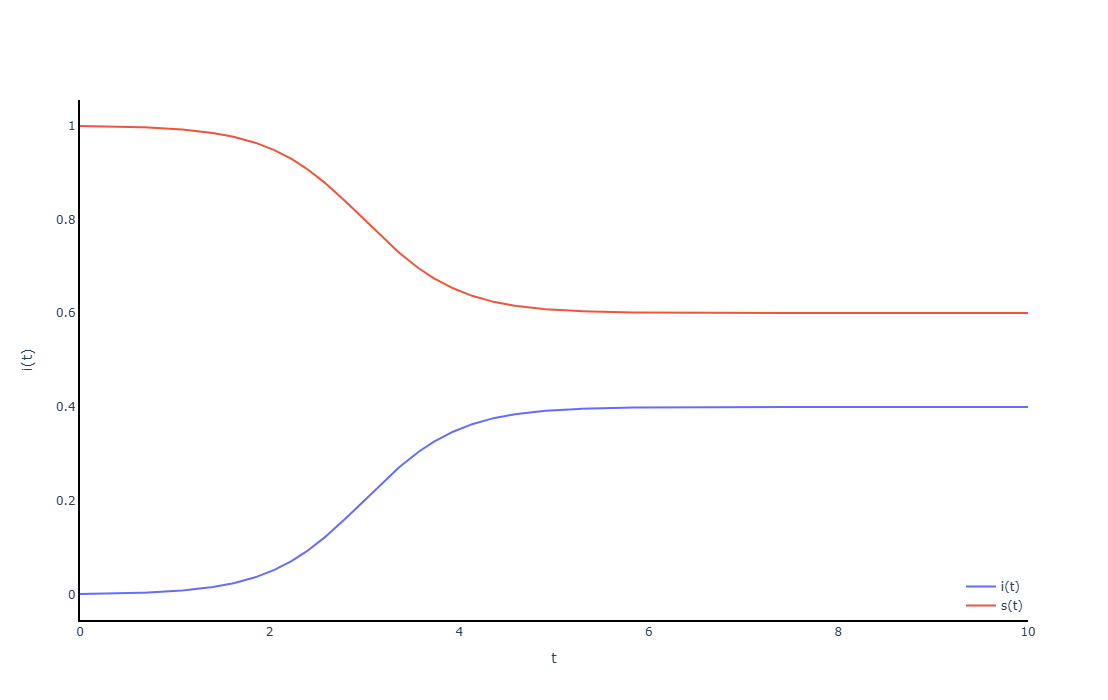

In [4]:
beta = 0.5
k = 10
mu = 3

t = np.linspace(0, 10, 400)

def sis(t, i0, beta, k, mu):
    C = i0/(1-i0-mu/(beta*k))
    I_t = (1-mu/(beta*k))*(C*np.exp((beta*k-mu)*t)/(1+C*np.exp((beta*k-mu)*t)))
    return [I_t, 1-I_t]

i0 = 0.001

fig = go.Figure()

Y = sis(t, i0, beta, k, mu)
fig.add_trace(go.Scatter(x=t, y=Y[0], mode='lines', name='i(t)'))
fig.add_trace(go.Scatter(x=t, y=Y[1], mode='lines', name='s(t)'))

fig.update_layout(
    xaxis_title='t',
    yaxis_title='i(t)',
    xaxis=dict(showgrid=False, linecolor='black', linewidth=2),
    yaxis=dict(showgrid=False, linecolor='black', linewidth=2),
    plot_bgcolor='white',
    width=700,
    height=700,
    legend=dict(
        x=1,
        y=0,
        xanchor='right',
        yanchor='bottom'
    )
)

fig.show()

## Susceptible-Infected-Recovered (SIR) Model

The equations describe the dynamics are:

$$ \frac{di}{dt} = - \mu i + \beta \langle k \rangle i s $$
$$ \frac{ds}{dt} = - \beta \langle k \rangle i s $$
$$ \frac{dr}{dt} = \mu i $$

This equations satisfy:

$$ \frac{di}{dt} + \frac{ds}{dt} + \frac{dr}{dt} = 0 $$

it follows that:

$$ s(t) + i(t) + r(t) = \text{constant} = 1 $$

By substituting $s = 1 - i - r$ we get:

$$ \frac{di}{dt} = - \mu i + \beta \langle k \rangle i (1 - r - i) $$
$$ \frac{ds}{dt} = - \beta \langle k \rangle i (1 - r - i) $$
$$ \frac{dr}{dt} = \mu i $$

In this model:

$$ R_0 = \frac{\beta \langle k \rangle}{\mu} $$

If $R_0 < 1$ the infection will die out.

In [74]:
def SIR(t, z, mu, beta, k):
    i, s, r = z
    return [-mu*i + beta*k*i*(1 - r - i), - beta*k*i*(1 - r - i), mu*i]

In [101]:
t_span = (0, 200)
z0 = [0.05, 0.95, 0]
beta = 0.1
k = 2
mu = 0.05

sol = solve_ivp(SIR, t_span, z0, args=(mu, beta, k), dense_output=True, max_step=0.1)

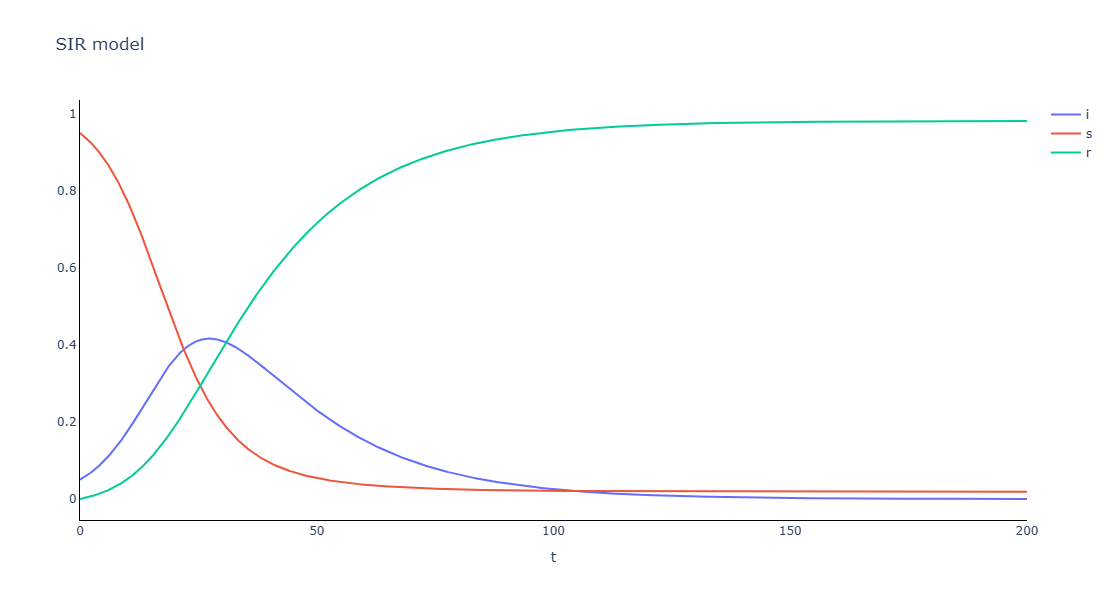

In [102]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=sol.t, y=sol.y[0], mode='lines', name='i'))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[1], mode='lines', name='s'))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[2], mode='lines', name='r'))

fig.update_layout(
    title='SIR model',
    xaxis_title='t',
    yaxis_title=' ',
    showlegend=True,
    height=600,
    width=600,
    plot_bgcolor='white',  
    xaxis=dict(
        showgrid=False,  
        linecolor='black'  
    ),
    yaxis=dict(
        showgrid=False, 
        linecolor='black'  
    )
)

fig.show()

## Summary

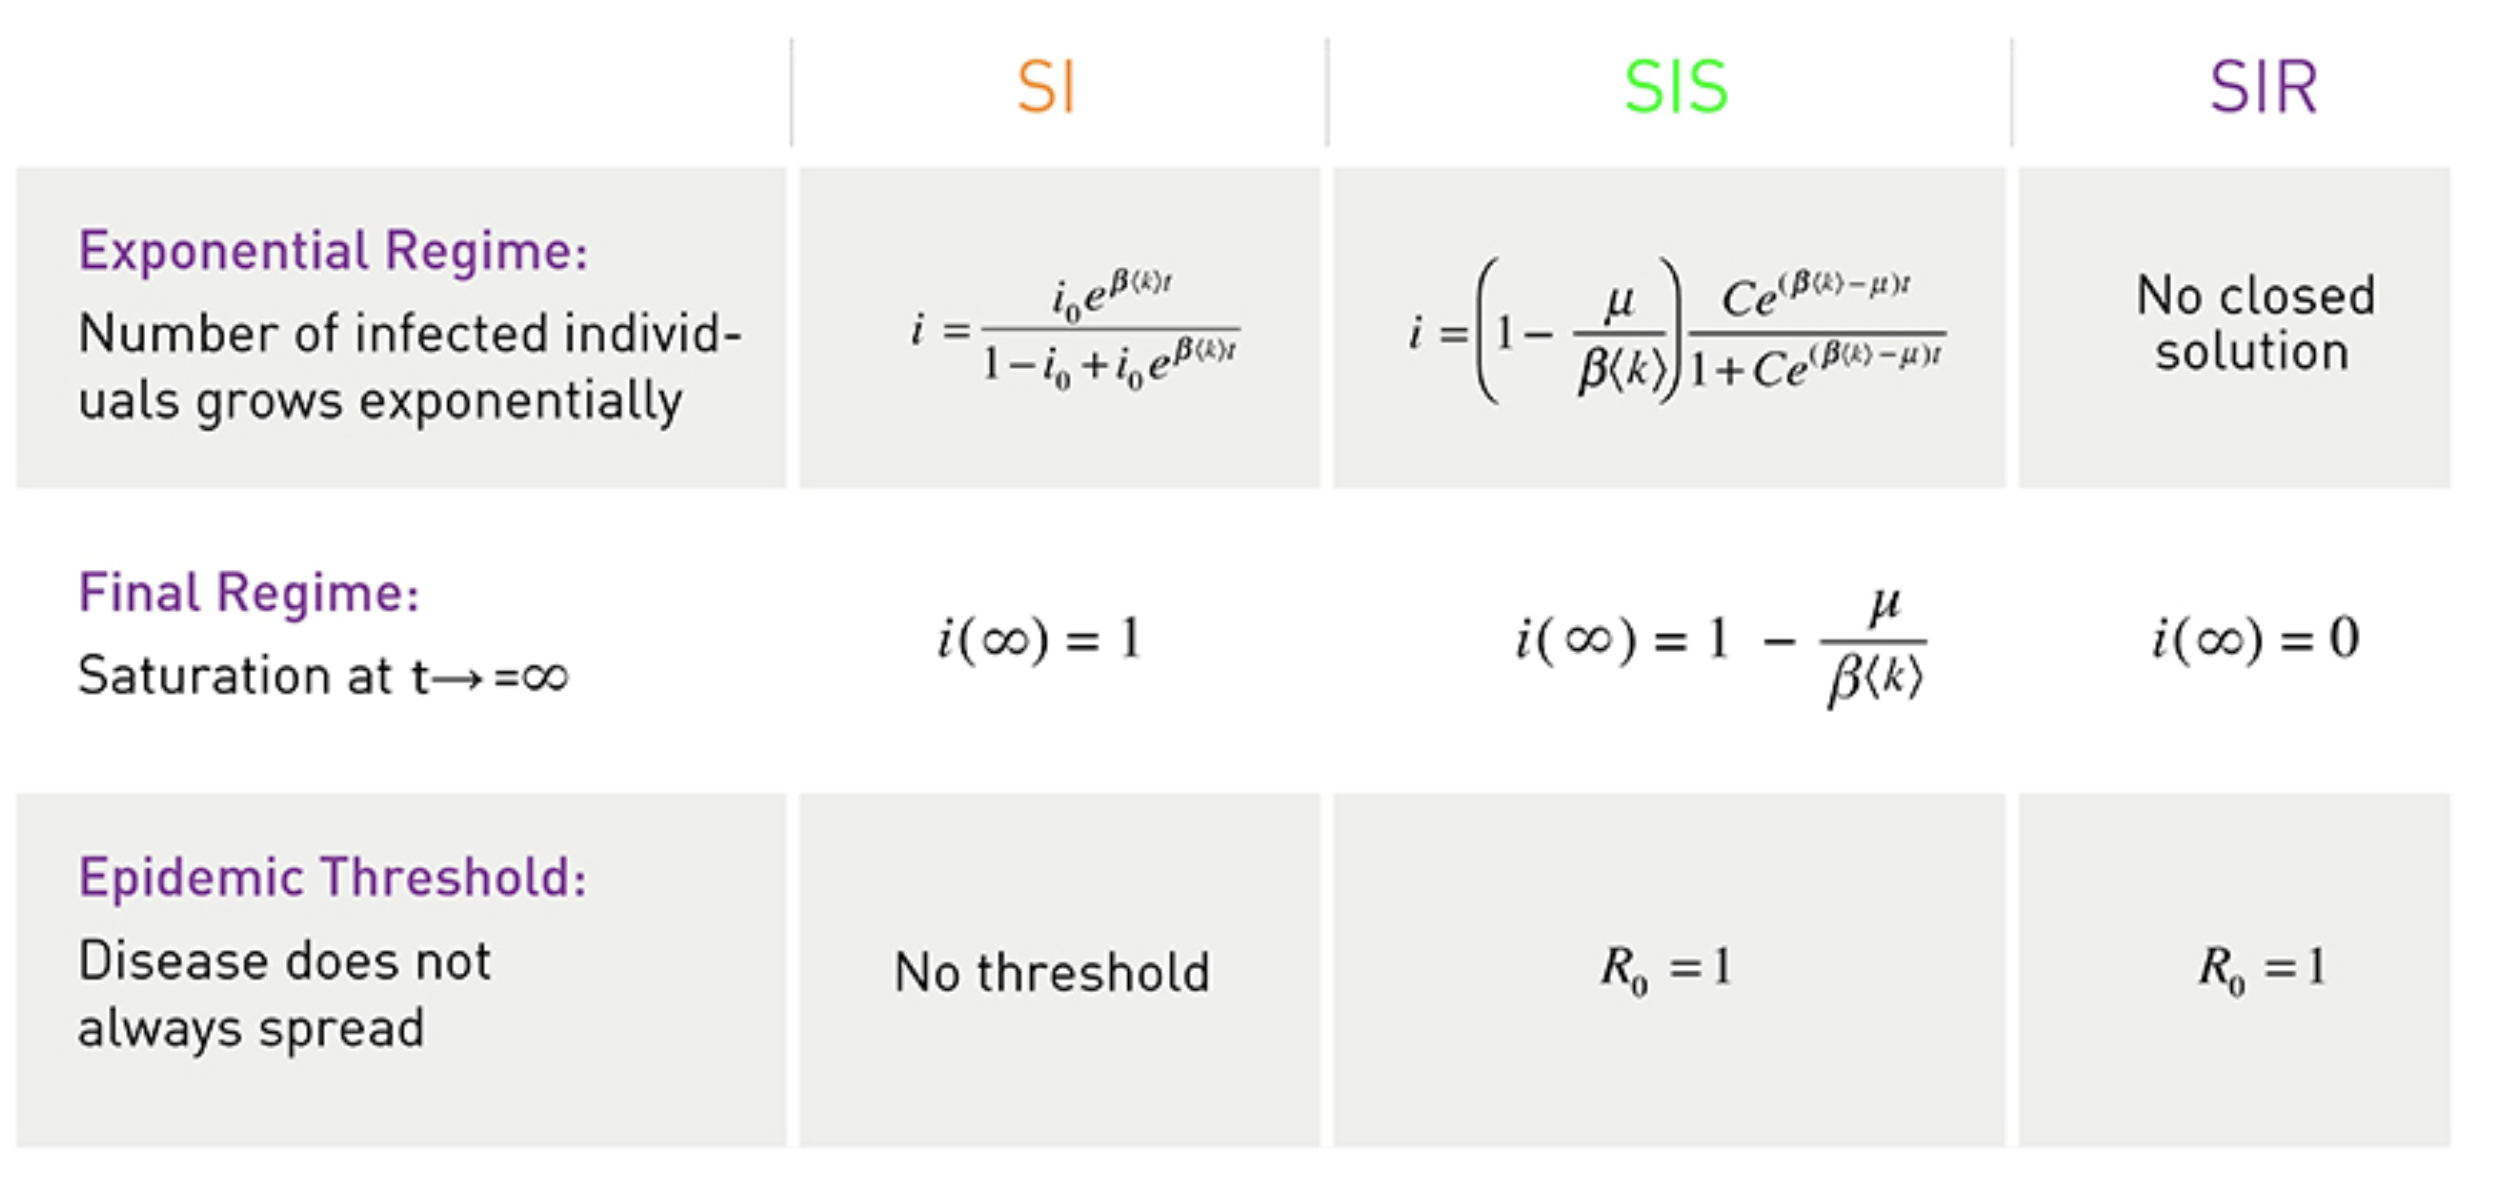

## Network representation

The previous representation of epidemic models has several disadvantages:

1) It not incorporate the structure of the contact network that facilitates the spread of a pathogen. 

2) It assume that any individual can come into contact with any other individual (homogeneous mixing hypothesis) and that all individuals have a comparable number of contacts, $\langle k \rangle$.

Both assumptions are false: Individuals can transmit a pathogen only to those they come into contact with, hence pathogens spread on a complex contact network. Furthermore, these contact networks are often scale-free, hence $\langle k \rangle$ is not sufficient to characterize their topology.

If a pathogen spreads on a network, individuals with more links are more likely to be in contact with an infected individual, hence they are more likely to be infected. Therefore, the mathematical formalism must consider the degree of each node as an implicit variable. This is achieved by the degree block approximation, which distinguishes nodes based on their degree and assumes that nodes with the same degree are statistically equivalent. Therefore we denote with

$$
i_k = \frac{I_k}{N_k}
$$

the fraction of nodes with degree $k$ that are infected among all $N_k$ degree-$k$ nodes in the network. The total fraction of infected nodes is the sum of all infected degree-$k$ nodes

$$
i = \sum_k p_k i_k 
$$

## SI model - network representation

Given the different node degrees, we write the SI model for each degree $k$ separately:

$$
\frac{di_k}{dt} = \beta (1 - i_k) k \Theta_k 
$$

Similarly to the previous representation, the infection rate is proportional to $\beta$ and the fraction of degree-$k$ nodes that are not yet infected, which is $(1 - i_k)$. Yet, there are some key differences:

1. The average degree $\langle k \rangle$ is replaced with each node’s actual degree $k$.
2. The density function $\Theta_k$ represents the fraction of infected neighbors of a susceptible node $k$. In the homogenous mixing assumption $\Theta_k$ is simply the fraction of the infected nodes, $i$. In a network environment, however, the fraction of infected nodes in the vicinity of a node can depend on the node’s degree $k$ and time $t$.

The network representation represents a system of $k_{max}$ coupled equations, one equation for each degree present in the network.

we can approximate the equation with

$$ \frac{di_k}{dt} \approx \beta k \Theta_k $$

One can show, for a network lacking degree correlations the $ \Theta_k $ function is independent of $ k $, so we get:

$$ \frac{di_k}{dt} \approx \beta k \frac{i_0 \langle k \rangle - 1}{\langle k \rangle} e^{t / \tau_{SI}} $$

where $ \tau_{SI} $ is the characteristic time for the spread of the pathogen

$$ \tau_{SI} = \frac{\langle k \rangle}{\beta (\langle k^2 \rangle - \langle k \rangle)} $$

Integrating the approximated equation we obtain the fraction of infected nodes with degree $ k $

$$ i_k = i_0 \left( 1 + k \frac{\langle k \rangle - 1}{\langle k^2 \rangle - \langle k \rangle} \left( e^{t / \tau_{SI}} - 1 \right) \right) $$

This equation makes several important predictions:

- The higher the degree of a node, the more likely that it becomes infected.
- The total fraction of infected nodes grows with time as

$$ i = \int_0^{k_{max}} i_k p_k dk = i_0 \left( 1 + \frac{\langle k \rangle^2 - \langle k \rangle}{\langle k^2 \rangle - \langle k \rangle} \left( e^{t / \tau_{SI}} - 1 \right) \right) $$

- The characteristic time $ \tau $ depends not only on $ \langle k \rangle $, but also on the network’s degree distribution through $ \langle k^2 \rangle $. To fully understand the significance of the prediction, let us derive $ \tau_{SI} $ for different networks:

#### Random Network

For a random network $ \langle k^2 \rangle = \langle k \rangle (\langle k \rangle + 1) $, obtaining

$$ \tau_{SI}^{ER} = \frac{1}{\beta \langle k \rangle} $$

##### Scale-free Network with $ \gamma \geq 3 $

If the contact network on which the disease spreads is scale-free with degree exponent $ \gamma \geq 3 $, both $ \langle k \rangle $ and $ \langle k^2 \rangle $ are finite. Consequently $ \tau_{SI} $ is also finite and the spreading dynamics is similar to the behavior predicted for a random network but with an altered $ \tau_{SI} $.

#### Scale-free Networks with $ \gamma \leq 3 $

For $ \gamma < 3 $ in the $ N \to \infty $ limit $ \langle k^2 \rangle \to \infty $ hence $ \tau_{SI} \to 0 $. In other words, the spread of a pathogen on a scale-free network is instantaneous. This is perhaps the most unexpected prediction of network epidemics.